In [1]:
import torch
import numpy as np 
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

# Notations
Similar to [wikipedia](https://en.wikipedia.org/wiki/Gamma_distribution). 

$$X \sim \Gamma(\alpha, \beta)$$

The probability distribution function is given by 

$$f(x;\alpha,\beta)=\dfrac{x^{\alpha - 1}e^{-\beta x}\beta^{\alpha}}{\Gamma(\alpha)}$$

where $\Gamma(\alpha)=(\alpha - 1)!$

$\alpha$ is the shape parameter. 

$\beta$ is the rate parameter (we will fix this parameter to $\beta=5.0$ throughout this work). 

# PyTorch Notations

[Link](https://pytorch.org/docs/stable/distributions.html#gamma)

`torch.distributions.gamma.Gamma(concentration, rate, validate_args=None)`

Creates a Gamma distribution parameterized by shape concentration and rate.

# Analysis

### Steps
- The data is generated from the Gamma distribution.
- The parameter $\beta$ is fixed to $\beta=5.0$.
- Only one parameter, $\alpha$ varied. 
- Assume a normal prior on $\alpha$, that is, $p(\alpha)=\mathcal{N}(\alpha_{*},1)$
- Goal: compute evidence with and without compression. 
- Goal: use the score function for compression.
- Goal: compare with the case when a Gaussian likelihood is used. 


### Bayes' theorem

$$p(\alpha, \beta|\boldsymbol{x})=\dfrac{p(\boldsymbol{x}|\alpha, \beta)\,p(\alpha,\beta)}{p(\boldsymbol{x})}$$

$p(\beta)=\delta(\beta - 5.0)$. We will ignore $\beta$ below since it is fixed. 

$$p(\alpha|\boldsymbol{x})=\dfrac{p(\boldsymbol{x}|\alpha)\,p(\alpha)}{p(\boldsymbol{x})}$$

#### Without Compression

$$p(\boldsymbol{x})=\int \Gamma(\alpha, \beta=5.0)\,p(\alpha)\,\textrm{d}\alpha$$

Assume we have generated $N$ iid samples, $\boldsymbol{x}\in \mathbb{R}^{N}$:

$$p(\boldsymbol{x})=\int \prod_{i=1}^{N} f(x_{i};\alpha,\,\beta=5.0)\,p(\alpha)\,\textrm{d}\alpha$$

We can do this integration numerically (on a grid). 

If we assume a Gaussian likelihood, 

$$p(\boldsymbol{x})=\int \prod_{i=1}^{N} f(x_{i};\mu,\,\sigma=1.0)\,p(\mu)\,\textrm{d}\mu$$


#### With Compression
We will be using the score function, that is, 

$$s = \nabla\mathcal{L}$$

where $\mathcal{L}$ is the log-likelihood. We need the derivative of the log-likelihood with respect to $\alpha$, but evaluated at each sample. The log-likelihood when using the Gamma distribution is:

$$\mathcal{L}=\sum_{i=1}^{N}\textrm{log}\,f(x_{i};\alpha,\beta=5.0)$$

and the derivative of the log-likelihood with respect to the parameter, $\alpha$ is:

$$\nabla\mathcal{L}=\nabla\sum_{i=1}^{N}\textrm{log}\,f(x_{i};\alpha,\beta=5.0)$$

Therefore, we have compressed $N$ samples (data points) to just 1 number. The likelihood (for the compressed data) is 

$$p(s|\alpha)=\dfrac{1}{\sqrt{2\pi\sigma_{*}^{2}}}\,\textrm{exp}\left[-\frac{1}{2}\dfrac{(s-s_{*})^{2}}{\sigma_{*}^{2}}\right]$$

where $s_{*}=\nabla\mathcal{L}(\alpha=\alpha_{*})$ and $\sigma_{*}^{2}=-\nabla^{2}\mathcal{L}(\alpha=\alpha_{*})$. $\alpha_{*}$ is a chosen fiducial point. 

### Explore the Gamma Distribution

In [2]:
shape = 10.0

# the rate is fixed 
rate = 5.0

dist = torch.distributions.gamma.Gamma(shape, rate)

samples = dist.rsample([10000]).view(-1)

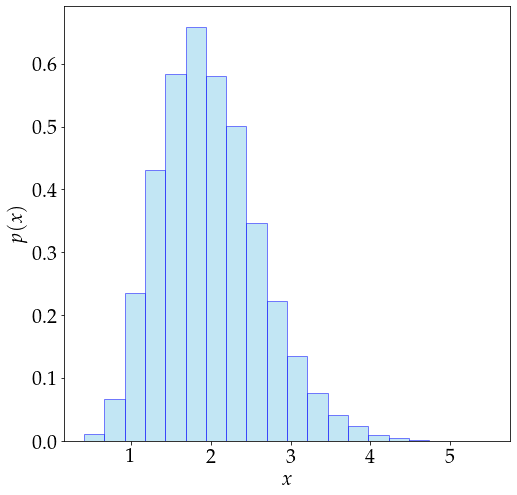

In [3]:
plt.figure(figsize=(8,8))
plt.hist(samples, density=True, bins=20, ec='b', alpha=0.5, color='skyblue')
plt.ylabel(r'$p(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

### Data
This is our data vector of size 500 and is fixed throughout the analysis. 

In [4]:
data = dist.rsample([300]).view(-1)

# Gamma Distribution Likelihood

### Parameter Estimation Case
We can infer $\alpha$ from the data (sanity check). 

In [5]:
def loglike_gamma(data, alpha: float, rate: float = 5.0):
    
    
    alpha = torch.tensor([alpha], dtype = torch.float32)
    
    rate = torch.tensor([rate], dtype = torch.float32)
    
    dist = torch.distributions.gamma.Gamma(alpha, rate)
    
    logp = dist.log_prob(data)
    
    loglike = torch.sum(logp).item()
    
    return loglike

In [6]:
def logprior_normal(alpha, mean: float = 10.0, sigma: float = 1.0):
    
    alpha = torch.tensor([alpha], dtype = torch.float32)
    
    mean = torch.tensor([mean], dtype = torch.float32)
    
    sigma = torch.tensor([sigma], dtype = torch.float32)
    
    dist = torch.distributions.normal.Normal(mean, sigma)
    
    logprior = dist.log_prob(alpha).item()
    
    return logprior

In [7]:
npoint = 1000
alpha_grid = torch.linspace(9.0, 11.0, npoint)
logpost_gamma = torch.zeros(npoint)

In [8]:
for i in range(npoint):
    
    # the value of alpha
    alpha_value = alpha_grid[i].item()
    
    # the log-posterior value
    logpost_gamma[i] = loglike_gamma(data, alpha_value)
    logpost_gamma[i] += logprior_normal(alpha_value)

In [9]:
# the pdf normalised by the maximum 
pdf_gamma = torch.exp(logpost_gamma - logpost_gamma.max())

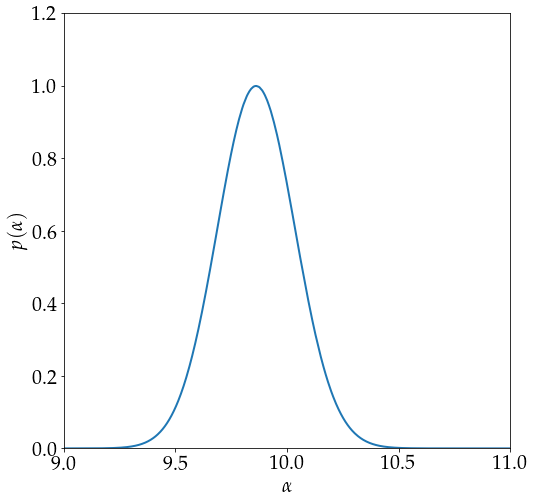

In [10]:
plt.figure(figsize = (8,8))
plt.plot(alpha_grid, pdf_gamma, lw = 2.0)
plt.ylabel(r'$p(\alpha)$', fontsize = fontSize)
plt.xlabel(r'$\alpha$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 1.2)
plt.xlim(min(alpha_grid), max(alpha_grid))
plt.show()

### Summary Statistics

In [11]:
pdf_gamma_norm = pdf_gamma/ torch.trapz(pdf_gamma, alpha_grid)

We can calculate the mean and variance as follows:

$$\mathbb{E}[\alpha] = \int \alpha\, p(\alpha|\boldsymbol{x})\,\textrm{d}\alpha$$

$$\textrm{var}[\alpha]=\int \alpha^{2}\, p(\alpha|\boldsymbol{x})\,\textrm{d}\alpha - \mathbb{E}^{2}[\alpha]$$

In [12]:
mean_alpha = torch.trapz(alpha_grid*pdf_gamma_norm, alpha_grid)

In [13]:
var_alpha = torch.trapz(alpha_grid**2 * pdf_gamma_norm, alpha_grid) - mean_alpha**2

In [14]:
print(f'The mean is {mean_alpha.item():.4f}')
print(f'The standard deviation is {var_alpha.sqrt().item():.4f}')

The mean is 9.8626
The standard deviation is 0.1741


Good - we expected a value around 10 since the samples (data) were generated from $X\sim\Gamma(10.0, 5.0)$. 

### Evidence Estimate
We basically need to do a 1D-integration of the posterior (up to a normalisation constant). 

In [15]:
evi_gamma = torch.trapz(pdf_gamma, alpha_grid)

In [16]:
log_evi_gamma = logpost_gamma.max().item() + torch.log(evi_gamma)

In [17]:
log_evi_gamma

tensor(-283.0836)

# Normal Distribution Likelihood

### Parameter Estimation Case

In [18]:
def loglike_normal(data, mean, sigma: float = 1.0):
    
    mean = torch.tensor([mean], dtype = torch.float32)

    sigma = torch.tensor([sigma], dtype = torch.float32)
    
    dist = torch.distributions.normal.Normal(mean, sigma)
    
    logp = dist.log_prob(data)
    
    loglike = torch.sum(logp).item()
    
    return loglike

Looking at the Gamma distribution above, the mean is roughly centered on 2. 

In [19]:
npoint = 1000
mu_grid = torch.linspace(1.5, 2.5, npoint)
logpost_normal = torch.zeros(npoint)

In [20]:
for i in range(npoint):
    
    # the value of alpha
    mu_value = mu_grid[i].item()
    
    # the log-posterior value
    logpost_normal[i] = loglike_normal(data, mu_value)
    
    # add the prior contribution with a mean = 2.0 and standard deviation = 1.0
    logpost_normal[i] += logprior_normal(mu_value, 2.0, 1.0)

In [21]:
# the pdf normalised by the maximum 
pdf_normal = torch.exp(logpost_normal - logpost_normal.max())

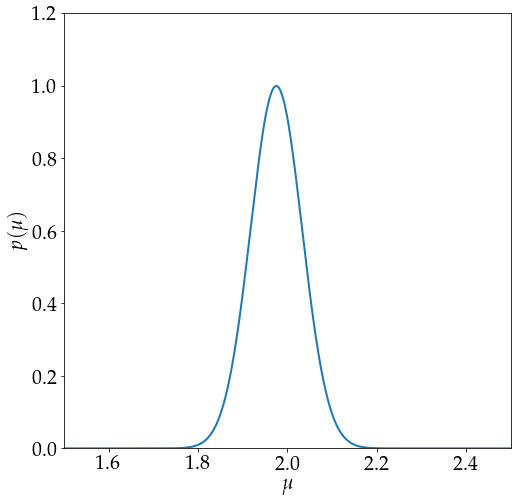

In [22]:
plt.figure(figsize = (8,8))
plt.plot(mu_grid, pdf_normal, lw = 2.0)
plt.ylabel(r'$p(\mu)$', fontsize = fontSize)
plt.xlabel(r'$\mu$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 1.2)
plt.xlim(min(mu_grid), max(mu_grid))
plt.show()

In [23]:
evi_normal = torch.trapz(pdf_normal, mu_grid)

In [24]:
log_evi_normal = logpost_normal.max().item() + torch.log(evi_normal)

In [25]:
log_evi_normal 

tensor(-339.0552)

In [26]:
logBF = log_evi_gamma - log_evi_normal
print(f'The log-Bayes factor between Model 1 (Gamma) and Model 2 (Normal) is {logBF:.2f}')

The log-Bayes factor between Model 1 (Gamma) and Model 2 (Normal) is 55.97


Good - we expect the Gamma likelihood function to be better compared to a Gaussian likelihood function.

# Compression - Score Function

In [27]:
def score_compression_gamma(data, alpha: float, rate: float = 5.0):
    
    alpha = torch.tensor([alpha], dtype = torch.float32)
    
    # we need the derivatives with respect to the shape parameter
    alpha.requires_grad = True
    
    rate = torch.tensor([rate], dtype = torch.float32)
    
    dist = torch.distributions.gamma.Gamma(alpha, rate)
    
    # the log-likelihood 
    log_like = dist.log_prob(data).sum()
    
    # gradient of log-likelihood with respect to shape (alpha) 
    grad_log_like = torch.autograd.grad(log_like, alpha, create_graph=True)[0]
    
    # the second derivative with respect to shape (alpha)
    hessian = torch.autograd.grad(grad_log_like, alpha)[0]
    
    return grad_log_like.item(), hessian.item()

We will choose $\alpha=10.0$ as the expansion (fiducial) point. We can also quickly compute the Maximum Likelihood Estimator (MLE), that is, find $\alpha_{\textrm{MLE}}$ for which $\nabla\mathcal{L}=0$ and this happens at:

$$\alpha_{\textrm{MLE}}=\dfrac{\beta}{N}\sum_{i=1}^{N}x_{i}$$

In our work, $\beta=5.0$. So we want just compute $\alpha_{\textrm{MLE}}$.

In [28]:
# Maximum likelihood estimate 
torch.mean(data).item() * 5.0

9.87557053565979

In [29]:
# compress the data at the shape parameter = 10.0

s_data, h_data = score_compression_gamma(data, 10.0)

In [30]:
print(f'Error estimate of the score: {np.sqrt(-1.0 / h_data):.4f}')

Error estimate of the score: 0.1780


In [31]:
print(f'Previously, we estimated the standard deviation of the shape parameter using the posterior as: {var_alpha.sqrt().item():.4f}')

Previously, we estimated the standard deviation of the shape parameter using the posterior as: 0.1741


# ISSUE below

The pdf is *always* centred on the expansion point? and the error estimate on $\alpha$ does not look good!

In [32]:
def loglike_gamma_score(alpha, data, score, hessian, rate: float = 5.0):
    
    grad, _ = score_compression_gamma(data, alpha, rate)
    
    # print(grad)
    
    # calculate the variance (inverse of hessian)
    var = torch.tensor([-1. / hessian])
    
    std = torch.sqrt(var)
    
    gaussian = torch.distributions.normal.Normal(score, std)
    
    loglike = gaussian.log_prob(torch.tensor([grad]))
       
    return loglike 

In [33]:
logpost_gamma_score = torch.zeros(npoint)

In [34]:
alpha_test = torch.linspace(9.90, 10.10, 1000)
for i in range(npoint):
    
    # the value of alpha
    alpha_value = alpha_test[i].item()
    
    # the log-posterior value
    logpost_gamma_score[i] = loglike_gamma_score(alpha_value, data, s_data, h_data, rate = 5.0)
    logpost_gamma_score[i] += logprior_normal(alpha_value, 10.0, 1.0)

In [35]:
# the pdf normalised by the maximum 
pdf_gamma_score = torch.exp(logpost_gamma_score - logpost_gamma_score.max())

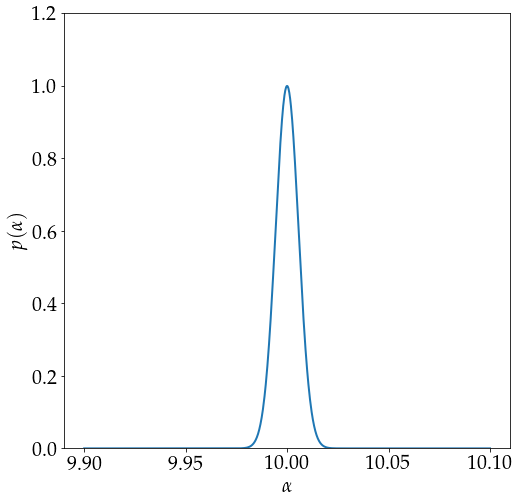

In [36]:
plt.figure(figsize = (8,8))
plt.plot(alpha_test, pdf_gamma_score, lw = 2.0)
plt.ylabel(r'$p(\alpha)$', fontsize = fontSize)
plt.xlabel(r'$\alpha$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 1.2)
# plt.xlim(min(alpha_grid), max(alpha_grid))
plt.show()

### Test
We can just sample the score, given the score function calculated at $\alpha=10.0$ and the error estimate. This looks good but we would expect the error estimate on $\alpha$ to be of the same width (since the Hessian is just the second derivative of the log-likelihoood with respect to the parameter $\alpha$). Maybe not - maybe we need a lot of data for the likelihood to peak. Maybe the likelihood surface is too broad. 

In [37]:
gaussian_test = torch.distributions.normal.Normal(s_data, np.sqrt(-1.0 / h_data))

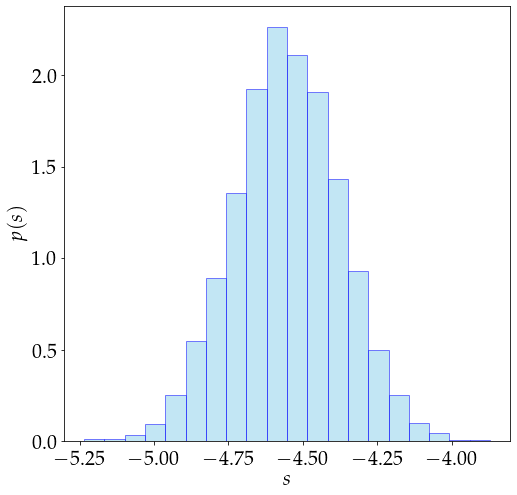

In [38]:
plt.figure(figsize=(8,8))
plt.hist(gaussian_test.rsample([10000]), density=True, bins=20, ec='b', alpha=0.5, color='skyblue')
plt.ylabel(r'$p(s)$', fontsize = fontSize)
plt.xlabel(r'$s$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()